In [28]:
import sys
import os
from matplotlib import pyplot as plt
import cv2
from augmentation import augment
from data_generator import DOTASequence

In [29]:
annot_path = 'data/train/annotations' #Path to directory of annotations
images_path = 'data/train/images' #Path to directory of images
generator = DOTASequence(images_path, annot_path, augmenter = augment)

In [ ]:
idx = 4
imgbatch, annotbatch = generator[idx]
img = imgbatch[0]
annot = annotbatch[0]

plt.figure(figsize = (25,25))

for line in annot:
    p1 = int(line[0]), int(line[1])
    p2 = int(line[2]), int(line[3])
    p3 = int(line[4]), int(line[5])
    p4 = int(line[6]), int(line[7])
    
    color = (0,255,255)
    cv2.line(img, p1, p2, color,2)
    cv2.line(img, p2, p3, color,2)
    cv2.line(img, p3, p4, color,2)
    cv2.line(img, p4, p1, color,2)

plt.imshow(img)

In [6]:
# Dank new visualizer for mask utilities and revamp augmentation function below vvvvvvvv

import augmentation
import masks
import cv2
import os
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
img_path = "./data/train/images"
box_path = "./data/train/annotations"
mask_path = "./data/masks"

if not(os.path.exists(mask_path)):
    os.makedirs(mask_path)

image_names = [x[:-4] for x in os.listdir(img_path) if x.endswith(".png")]

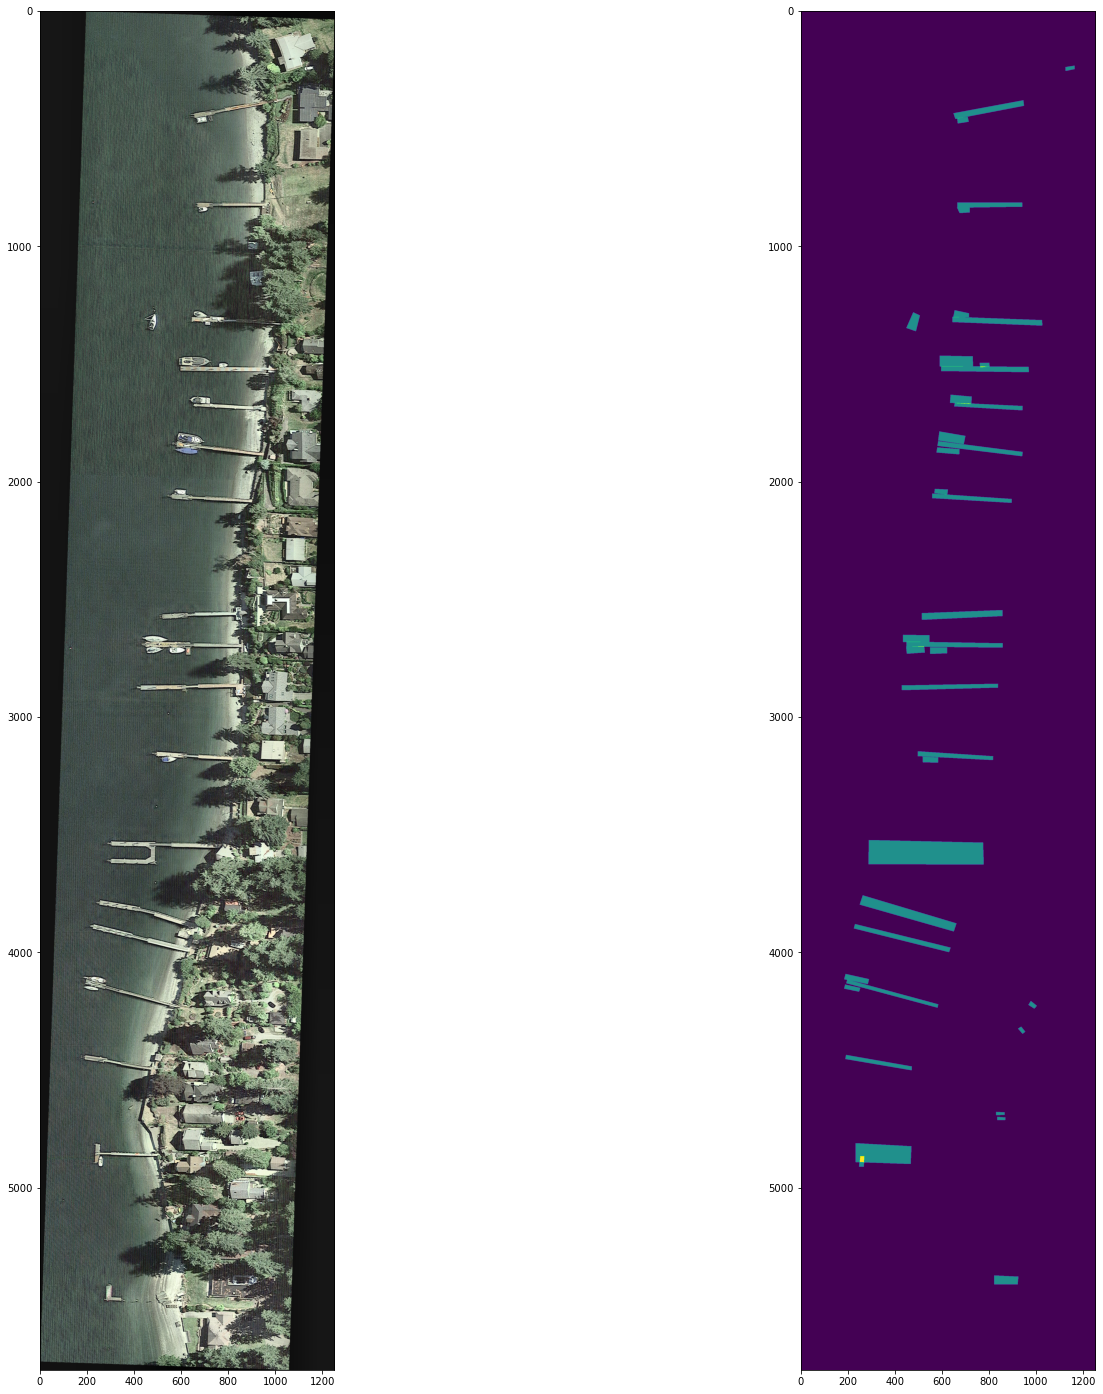

In [8]:
n = 1
index = image_names[n]

masks.save_mask(img_path, box_path, index, mask_path)
img = cv2.imread(os.path.join(img_path, index + '.png'))
mask = masks.load_mask(mask_path, index)

aimg, amask = augmentation.augment(img,mask)

agmask = np.zeros((amask.shape[0],amask.shape[1]),dtype = np.uint8)
for i in range(16):
    agmask = agmask + (amask[:,:,i])

plt.figure(figsize = (25,25))
plt.subplot(121)
plt.imshow(aimg)
plt.subplot(122)
plt.imshow(agmask)